In [1]:
from __future__ import division
from PIL import Image

from models import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import pandas as pd
from helper import maskAndResize, batch_image_mean, load_ood_detection_models

### Original Image

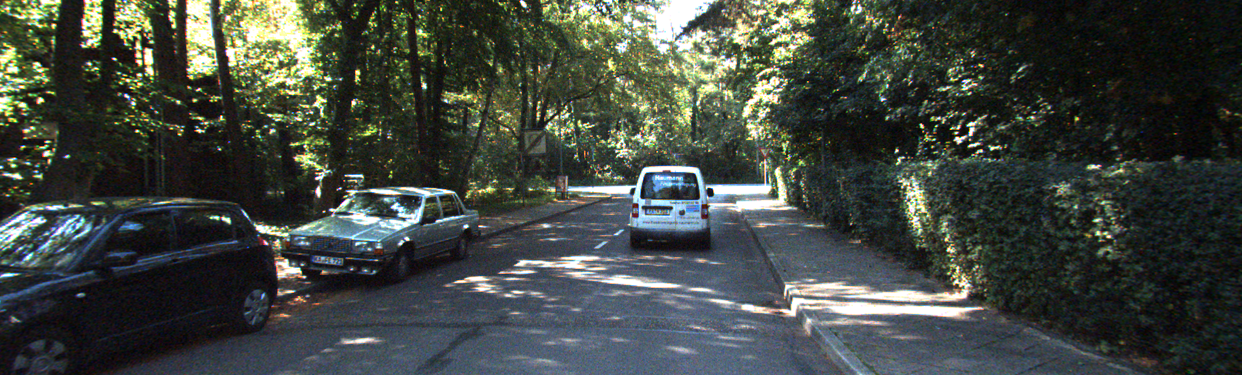

In [2]:
org_img_path = "demo/test_image"
org_img = Image.open(org_img_path + "/000089.png")
org_img

### YOLOv3 Detection

names:  ['Cars']

Performing object detection:
('demo/test_image/000089.png',)
	+ Batch 0, Inference Time: 0:00:01.473229

Saving images:
(0) Image: 'demo/test_image/000089.png'
	+ Label: Cars, Conf: 0.99999
	+ Label: Cars, Conf: 1.00000
	+ Label: Cars, Conf: 1.00000
	+ Label: Cars, Conf: 0.99996


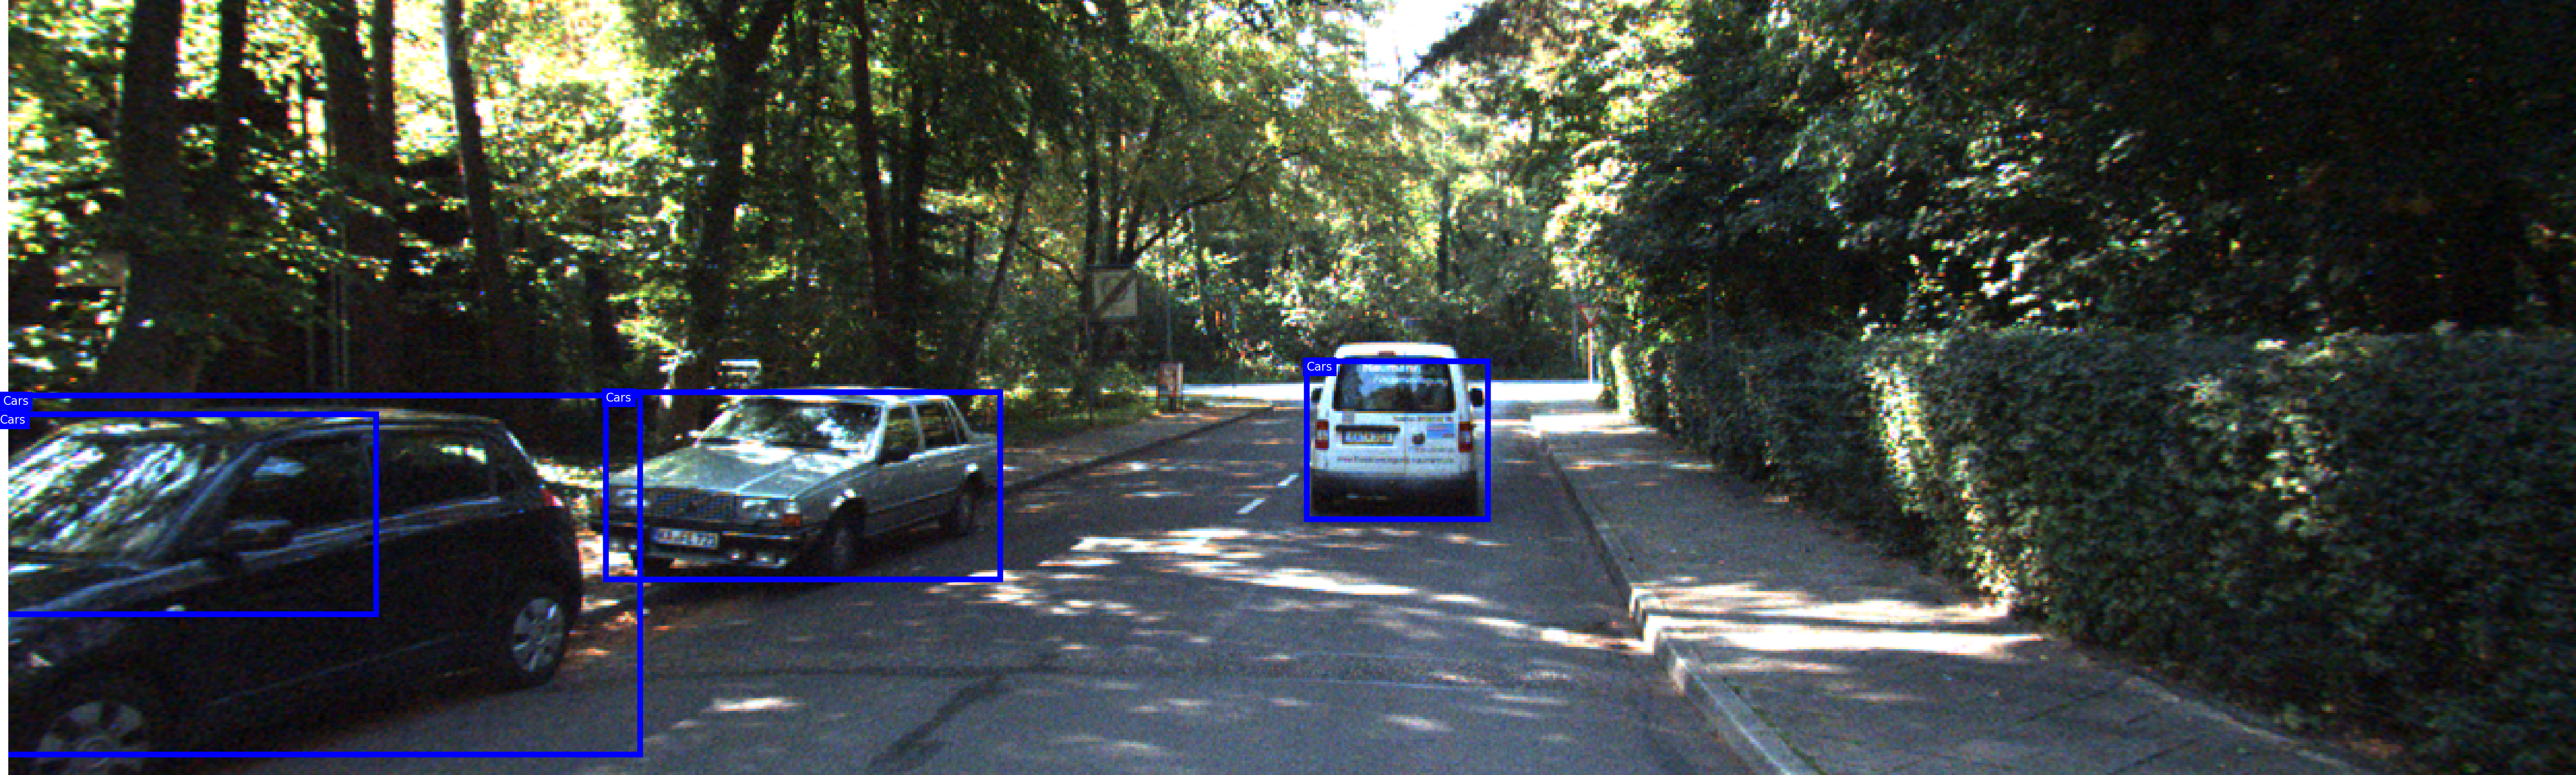

<Figure size 432x288 with 0 Axes>

In [6]:
img_w_bboxes = run_yolo_detection(org_img_path)
img_w_bboxes

### OOD Detection

names:  ['Cars']
OOD detection models loaded
Number of OOD objects in the image 1
I SENSE AN OOD OBJECT IN MY VICINITY!!!!!



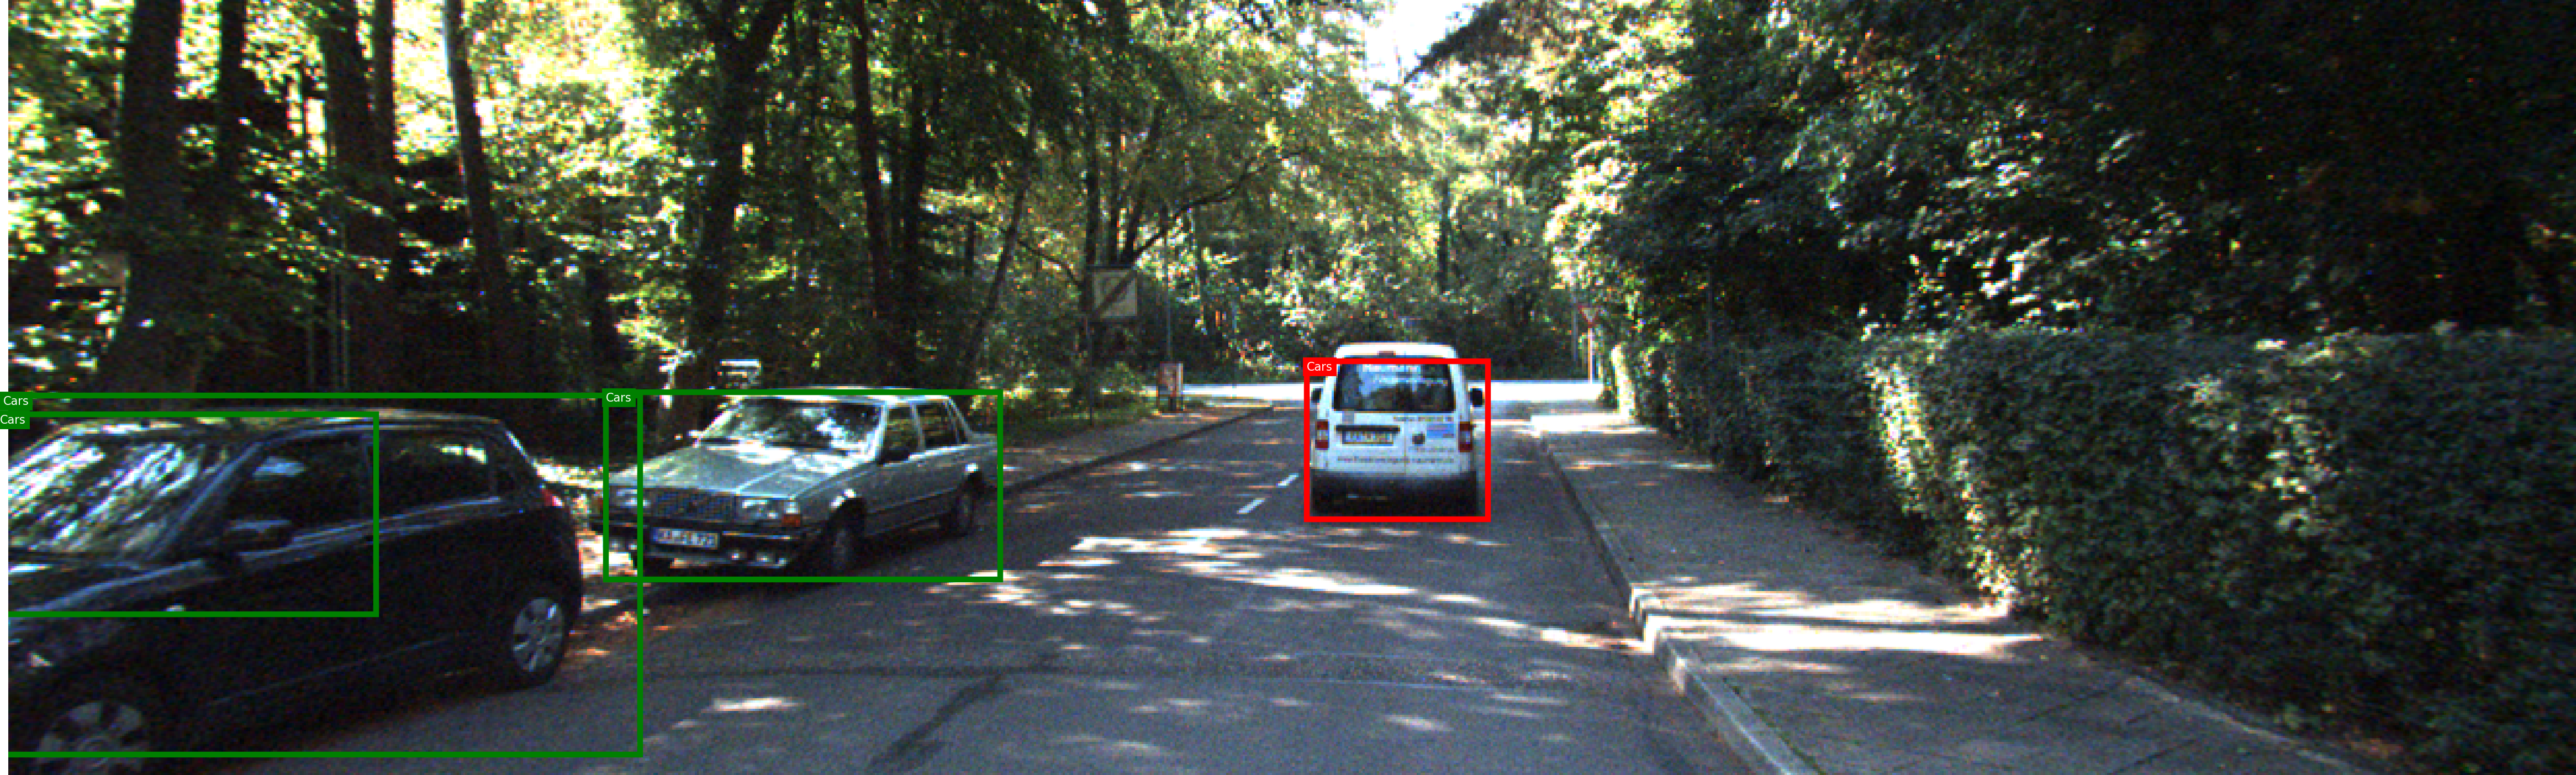

<Figure size 432x288 with 0 Axes>

In [11]:
img_w_id_bboxes = run_ood_detection(org_img_path)
# run_yolo_detection(org_img_path)
img_w_id_bboxes

### Function Implementations

In [4]:
def run_yolo_detection(org_img_path):
    image_folder = org_img_path
    output_folder = 'demo/yolo_output'
    model_def = 'yolov3-custom.cfg'
    weights_path = 'yolov3_ckpt_48.pth'
    class_path = 'classes.names'
    conf_thres = 0.8
    nms_thres = 0.4
    batch_size = 1
    n_cpu = 0
    img_size = 416
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs("output_folder", exist_ok=True)

    # Set up model
    model = Darknet(model_def, img_size=img_size).to(device)

    if weights_path.endswith(".weights"):
        # Load darknet weights
        model.load_darknet_weights(weights_path)
    else:
        # Load checkpoint weights
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

    model.eval()  # Set in evaluation mode

    dataloader = DataLoader(
        ImageFolder(image_folder, img_size=img_size),
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
    )

    classes = load_classes(class_path)  # Extracts class labels from file

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    imgs = []  # Stores image paths
    img_detections = []  # Stores detections for each image index

    print("\nPerforming object detection:")
    prev_time = time.time() 
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
        print(img_paths)
        img_names = img_paths[0].split('/')[-1]
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, conf_thres, nms_thres)

        # Log progress
        current_time = time.time()
        inference_time = datetime.timedelta(seconds=current_time - prev_time)
        prev_time = current_time
    #     log_df.loc[batch_i] = [img_names, inference_time, None, None]
        print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

        # Save image and detections
        imgs.extend(img_paths)
        img_detections.extend(detections)

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    print("\nSaving images:")
    # Iterate through images and save plot of detections
    for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):
    #     print("detections: ", detections)
        print("(%d) Image: '%s'" % (img_i, path))

        # Create plot
        img = np.array(Image.open(path))
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
    #         print("detections: ", detections.shape)
    #         print(img_size)
    #         print(img.shape)
            detections = rescale_boxes(detections, img_size, img.shape[:2])
    #         print(detections.shape)
    #         break
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            bbox_coords = []

            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:        
                bbox_coords.append(str(round(x1.item(), 3)) + ',' + str(round(x2.item(), 3)) + ',' + str(round(y1.item(), 3))  + ',' + str(round(y2.item(), 3)))
                print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=0.75, edgecolor="blue", facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=classes[int(cls_pred)],
                    color="white",
                    verticalalignment="top",
                    bbox={"color": "blue", "pad": 0},
                    fontsize = 1.5,
                )
            


        # Save generated image with detections
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        filename = path.split("/")[-1].split(".")[0]
        plt.savefig(f"{output_folder}/{filename}.png", bbox_inches="tight", pad_inches=0.0, dpi=1000)
        plt.close()
#     #     print(bbox_coords)
#         with open(f"{output_folder}/{filename}.txt", 'w') as f:
#             f.write('\n'.join(bbox_coords))
        
        image_w_detection = Image.open(f"{output_folder}/{filename}.png")
        return image_w_detection
            
        


In [10]:
def run_ood_detection(org_img_path):
    image_folder = org_img_path
    output_folder = "demo/ood_output"
    model_def = "yolov3-custom.cfg"
    weights_path = "yolov3_ckpt_48.pth"
    class_path = "classes.names"
    conf_thres = 0.8
    nms_thres = 0.4
    batch_size = 1
    n_cpu = 0
    img_size = 416


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(output_folder, exist_ok=True)

    # os.makedirs("output", exist_ok=True)
    # Set up model
    model = Darknet(model_def, img_size=img_size).to(device)

    if weights_path.endswith(".weights"):
        # Load darknet weights
        model.load_darknet_weights(weights_path)
    else:
        # Load checkpoint weights
        model.load_state_dict(torch.load(weights_path, map_location=torch.device("cpu")))

    model.eval()  # Set in evaluation mode

    dataloader = DataLoader(
        ImageFolder(image_folder, img_size=img_size),
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
    )

    classes = load_classes(class_path)  # Extracts class labels from file

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    imgs = []  # Stores image paths
    img_detections = []  # Stores detections for each image index

#     print("\nPerforming object detection:")
    prev_time = time.time()
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
        img_names = img_paths[0].split("/")[-1]
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, conf_thres, nms_thres)

        # Log progress
        current_time = time.time()
        #     inference_time = datetime.timedelta(seconds=current_time - prev_time)
        inference_time = round((current_time - prev_time) * 1000, 3)
        prev_time = current_time
    #     log_df_1.loc[batch_i] = [img_names, inference_time]
#         print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

        # Save image and detections
        imgs.extend(img_paths)
        img_detections.extend(detections)

        torch.cuda.empty_cache()

    # Bounding-box colors
    # cmap = plt.get_cmap("tab20b")
    # colors = [cmap(i) for i in np.linspace(0, 1, 20)]

#     print("\nSaving images:")
    # Iterate through images and save plot of detections

    model.train()

    # register hook for OODL
    features = {}


    def get_features(name):
        def hook(model, input, output):
            # print("output.shape: ", len(output))
            features[name] = output.detach()

        return hook


    model.module_list[9].conv_9.register_forward_hook(get_features("conv_9"))


    for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

        # logging_parameters
        num_bbox, oodl_feat_extract_time, osvm_inference_time = None, None, None

#         print("(%d) Image: '%s'" % (img_i, path))
        image_bboxs_feats = np.array([])
        image_bbox_batch = np.array([])
        # Create plot
        img = np.array(Image.open(path))
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
            detections = rescale_boxes(detections, img_size, img.shape[:2])
            
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
#             bbox_colors = random.sample(colors, n_cls_preds)

            feat_extract_start_time = time.time()

            bbox_coords = []
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                bbox_coords.append(
                    str(round(x1.item(), 3))
                    + ","
                    + str(round(x2.item(), 3))
                    + ","
                    + str(round(y1.item(), 3))
                    + ","
                    + str(round(y2.item(), 3))
                )
#                 print(
#                     "\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item())
#                 )
                #             print(bbox_coords[-1])
                bbox_coords_curr = bbox_coords[-1].split(",")

                bbox_coords_curr = [math.floor(float(x)) for x in bbox_coords_curr]
                x1, x2, y1, y2 = (
                    bbox_coords_curr[0],
                    bbox_coords_curr[1],
                    bbox_coords_curr[2],
                    bbox_coords_curr[3],
                )

                masked_img = maskAndResize(img, x1, y1, x2, y2)

                # count += 1
                # bbox_count += 1

                # aggregating all bbox in an img as a batch
                if image_bbox_batch.shape[0] > 0:
                    image_bbox_batch = np.append(
                        image_bbox_batch, masked_img.reshape((1, 3, 416, 416)), 0
                    )
                else:
                    image_bbox_batch = masked_img.reshape((1, 3, 416, 416))

                del masked_img


        if image_bbox_batch.shape[0] > 0:  # if any bboxs were captured
            # prediction
            image_bbox_batch = torch.tensor(image_bbox_batch).float()
            #         _ = model(image_bbox_batch.cuda())
            _ = model(image_bbox_batch)
            inter_features_batch = features["conv_9"]  # (n, 32, 416, 416)
            inter_features_batch = np.array(inter_features_batch.cpu())
            image_bboxs_feats = batch_image_mean(inter_features_batch)  # (n, 32)
            feat_extract_stop_time = time.time()
            #         oodl_feat_extract_time = datetime.timedelta(seconds=feat_extract_stop_time - feat_extract_start_time)
            oodl_feat_extract_time = round(
                (feat_extract_stop_time - feat_extract_start_time) * 1000, 3
            )
#             print("image_bboxs_feats: ", image_bboxs_feats.shape)

            num_bbox = image_bboxs_feats.shape[0]
            del image_bbox_batch, inter_features_batch
            osvm_model, ss_model = load_ood_detection_models(
                "trained_osvm_model.sav", "trained_ss_model.sav"
            )

            image_bboxs_feats_normalized = ss_model.transform(image_bboxs_feats)
            osvm_infer_start_time = time.time()
            pred_image_bbox = osvm_model.predict(image_bboxs_feats_normalized)
#             print(pred_image_bbox)
            osvm_infer_stop_time = time.time()

            #         osvm_inference_time = datetime.timedelta(seconds=osvm_infer_stop_time - osvm_infer_start_time)
            osvm_inference_time = round(
                (osvm_infer_stop_time - osvm_infer_start_time) * 1000, 3
            )

            n_errors = pred_image_bbox[pred_image_bbox == -1].size
            print("Number of OOD objects in the image", n_errors)
            if n_errors > 0:
                print("I SENSE AN OOD OBJECT IN MY VICINITY!!!!!")

            print()

            del image_bboxs_feats, image_bboxs_feats_normalized, img
        # log times
#         print("num_bbox: ", num_bbox)

#         print("oodl_feat_extract_time: ", oodl_feat_extract_time)

#         print("osvm_inference_time: ", osvm_inference_time)
#         print()

        # display bboxes after ood detection
        bbox_count = 0
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:        
    #         bbox_coords.append(str(round(x1.item(), 3)) + ',' + str(round(x2.item(), 3)) + ',' + str(round(y1.item(), 3))  + ',' + str(round(y2.item(), 3)))
    #         print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

    #         color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            if pred_image_bbox[bbox_count] == -1:
                color = "red"
            else:
                color = "green"
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=0.75, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
                fontsize = 1.5,
            )
            bbox_count +=1


        #     tmp = {"num_bbox": num_bbox, "OODL_feat_extraction_time": oodl_feat_extract_time, "OSVM_inference_time":osvm_inference_time}
    #     log_df_2.loc[img_i] = [
    #         num_bbox,
    #         oodl_feat_extract_time,
    #         osvm_inference_time,
    #         n_errors,
    #     ]
        # Save generated image with detections
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        filename = path.split("/")[-1].split(".")[0]
        plt.savefig(f"{output_folder}/{filename}.png", bbox_inches="tight", pad_inches=0.0, dpi=1000)
        plt.close()
        image_w_detection = Image.open(f"{output_folder}/{filename}.png")
        return image_w_detection
    #     #     print(bbox_coords)
    #     with open(f"{output_folder}/{filename}.txt", "w") as f:
    #         f.write("\n".join(bbox_coords))

    #     log_df = pd.concat((log_df_1, log_df_2), axis=1)
    #     log_df.to_csv("duckie_bot_log.csv")
#         torch.cuda.empty_cache()
